# Capstone Project
## OTHER EARTHS
Exoplanet-star Classifier


## TRAINING AND TESTING

In [204]:
#Importing Libraries
import pandas as pd
import numpy as np
import os
import boto3
import sagemaker
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from random import sample 
import tarfile
from sklearn.metrics import accuracy_score 

In [205]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [206]:
data_dir = 'data'
prefix = 'exoplanet'

input_data=sagemaker_session.upload_data(path = data_dir, key_prefix=prefix)

### Modeling

#### Model Architecture

In [207]:
!pygmentize source_pytorch/model.py

# torch imports
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, Linear, MaxPool1d, ReLU, Sigmoid, BatchNorm1d, Dropout

class Classifier(nn.Module):
    """
    Performs binary classification.
    The network should accept your number of features as input, and produce 
    a single sigmoid value, that can be rounded to a label: 0 or 1, as output.
    
    Notes on training:
    To train the classifier in PyTorch, use BCEWithLogitsLoss with 'pos_weights argument'.
    
    """

    def __init__(self):
        super(Classifier, self).__init__()
        
        # Layers
        self.conv1 = Conv1d(in_channels=1, out_channels=8, kernel_size=11)
        self.conv2 = Conv1d(8,16,11)
        self.conv3 = Conv1d(16,32,11)
        self.conv4 = Conv1d(32,64,11)
        
        self.pool = MaxPool1d(4, stride=2)
        
        self.fc1 = Linear(12032, 5000)
        self.fc2 = Linear(5000, 1000)
        self.fc3 = Linear(1000, 100)
        self.fc4 = Linear(1

#### Creating a pytorch estimator

In [263]:
from sagemaker.pytorch import PyTorch

# 'class_weight_0' and 'class_weight_1' are the weights for the ratio in which the training data 
# for label 0 and 1 respectively has to be sampled in order to mitigate class imbalance
epochs=100
estimator = PyTorch(entry_point="train.py",
                    source_dir="source_pytorch",
                    role=role,
                    framework_version='1.5.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=("s3://"+bucket+"/"+prefix),
                    hyperparameters={
                        'epochs': epochs,
                        'class_weight_0': 7,
                        'class_weight_1': 3
                    })

#### Training the estimator

In [264]:
%%time

estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-27 02:09:51 Starting - Starting the training job...
2020-10-27 02:09:53 Starting - Launching requested ML instances......
2020-10-27 02:11:00 Starting - Preparing the instances for training......
2020-10-27 02:12:06 Downloading - Downloading input data......
2020-10-27 02:13:20 Training - Downloading the training image............
2020-10-27 02:15:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-10-27 02:15:12,053 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-10-27 02:15:12,078 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-10-27 02:15:13,505 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-10-27 02:15:13,801 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2

#### Learning and Accuracy Curves

In [265]:
estimator.latest_training_job.name

'pytorch-training-2020-10-27-02-09-50-132'

In [266]:
filename='output.tar.gz'
s3 = boto3.client('s3')
s3.download_file(bucket,os.path.join(prefix,estimator.latest_training_job.name,'output',filename),filename)

In [268]:
filename = 'output.tar.gz'
with tarfile.open(filename) as tf:
    tf.extractall('train_data')

In [282]:
train_loss=[]
train_accuracy=[]
validation_loss=[]
validation_accuracy=[] 

with open('train_data/train_loss.txt') as losses:
    for i in range(0,epochs):
        train_loss.append(float(losses.readline()))
        
with open('train_data/val_loss.txt') as losses:
    for i in range(0,epochs):
        validation_loss.append(float(losses.readline()[7:13]))
        
with open('train_data/train_acc.txt') as accuracies:
    for i in range(0,epochs):
        train_accuracy.append(float(accuracies.readline()))
        
with open('train_data/val_acc.txt') as accuracies:
    for i in range(0,epochs):
        validation_accuracy.append(float(accuracies.readline()))
        


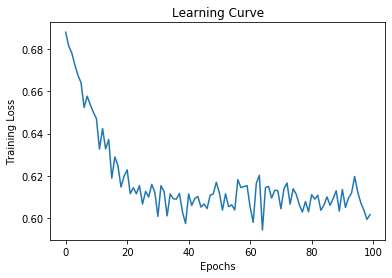

In [283]:
plt.title("Learning Curve")
plt.plot(range(0,epochs),train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

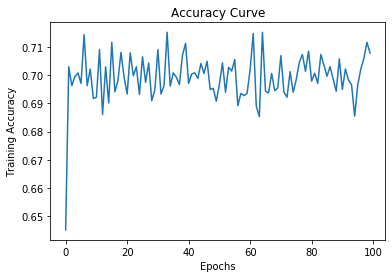

In [286]:
plt.title("Accuracy Curve")
plt.plot(range(0,epochs),train_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

#### Deploying the model

In [272]:
from sagemaker.pytorch import PyTorchModel
model = PyTorchModel(entry_point="predict.py", 
                     source_dir="source_pytorch", 
                     framework_version='1.5.0',
                     model_data=estimator.model_data,
                     role=role
                    )

# deploy your model to create a predictor
predictor = model.deploy(initial_instance_count=1,instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

#### Prediction and Evaluation

In [275]:
#taking first 500 test samples separately due to the limitations in the 
#amount of data that can be predicted by the predictor in each inference

test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
test_y = test_data.iloc[:,-1]
test_x = test_data.iloc[:,:-1]

# generate predicted class labels
test_y_preds = predictor.predict(torch.from_numpy(np.array(test_x[:500])).unsqueeze(1).float())
test_y_preds = np.concatenate([test_y_preds, predictor.predict(torch.from_numpy(np.array(test_x[500:])).unsqueeze(1).float())])

assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'

In [280]:
accuracy = accuracy_score(test_y,test_y_preds)

print("Accuracy: {}".format(accuracy))

Accuracy: 0.9912280701754386
